In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from camcan.datasets import load_camcan_rest
from nipype.algorithms.confounds import FramewiseDisplacement
from joblib import Parallel, delayed
import seaborn.apionly as sns
from sklearn.svm import LinearSVR
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

In [9]:
DATA_DIR = '/home/mehdi/data/camcan/camcan_preproc'
CAMCAN_CSV_FILE = '/home/mehdi/data/camcan/cc700-scored/participant_data.csv'
CAMCAN_PATIENTS_EXCLUDED = '/home/mehdi/data/camcan/camcan_preproc/'\
                           'excluded_subjects.csv'


## Analysis of the correlation between framewise displacement (FD) and age

- Correlation between FD and age.
- Age prediction from averaged FD.

Power, J. D., Barnes, K. A., Snyder, A. Z., Schlaggar, B. L., & Petersen, S. E. (2012). Spurious but systematic correlations in functional connectivity MRI networks arise from subject motion. Neuroimage, 59(3), 2142-2154.


In [14]:
# load resting-state data
dataset = load_camcan_rest(
    data_dir=DATA_DIR,
    patients_info_csv=CAMCAN_CSV_FILE,
    patients_excluded=CAMCAN_PATIENTS_EXCLUDED)

print('%u FD files' % len(dataset.fd))


626 FD files


In [27]:
# parse all FD files
fd_all = np.array([np.loadtxt(fd_file, skiprows=1) for fd_file in dataset.fd])

print(fd_all.shape)

(626, 260)


### Scatter plot of FD and age

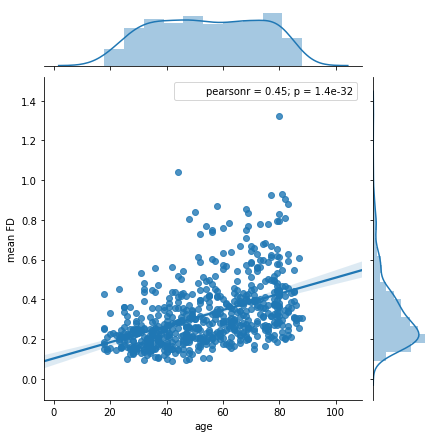

In [37]:
# y: age
y = np.array(dataset.scores['age'])
# x: mean FD
x = fd_all.mean(1)

# plot age vs FD
g = sns.jointplot(y, x, kind="reg")
g.set_axis_labels('age', 'mean FD')

## Age prediction from

In [36]:
x = x.reshape(-1, 1)
svr = LinearSVR()
kf = KFold(n_splits=10, shuffle=True, random_state=42)
r2s, maes = [], []
ytrue, ypred = [], []
for iteration, (train, test) in enumerate(kf.split(x)):
    svr.fit(x[train], y[train])
    ypred = svr.predict(x[test])
    r2 = svr.score(x[test], y[test])
    mae = mean_absolute_error(y[test], ypred)
    maes.append(mae)
    r2s.append(r2)

print('Age regression accuracy: R^2 %.2f - MAE %.2f' % (np.mean(r2s), np.mean(maes)))
    

Age regression accuracy: R^2 0.15 - MAE 14.36
